In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay

In [2]:
# This cell should be edited to match the data to be inspected.

# Which calibration type to analyse.
calibType = 'flat'
physical_filter = 'BG40_65mm_1~empty'
# Camera
cameraName = 'LATISS'

# Set which display to use.
haveDisplay=True
try:
    afwDisplay.setDefaultBackend("astrowidgets")
    display = afwDisplay.Display(dims=(1000, 1000))
except Exception as e:
    haveDisplay=False
    print(f"Recieved exception {e} while loading astrowidgets.  Disabling display.")
    
# Collection that the calibration was constructed in.
genCollection = 'LATISS/calib/DM-37587/flatGen-BG40.20230113a'
# Collection name containing the verification outputs.
verifyCollection = 'LATISS/calib/DM-37587/verifyFlat-BG40.20230113a'

Recieved exception name 'astrowidgets' is not defined while loading astrowidgets.  Disabling display.


In [3]:
# Get butler and camera
butler = dB.Butler("/repo/embargo/", collections=[verifyCollection, genCollection])
camera = butler.get('camera', instrument=cameraName)

In [4]:
# Get Run Statistics
runStats = butler.get('verifyFlatStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [5]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

2023011200107,ALL PASS
2023011200108,ALL PASS
2023011200109,ALL PASS
2023011200110,ALL PASS
2023011200111,ALL PASS
2023011200112,ALL PASS
2023011200113,ALL PASS
2023011200114,ALL PASS
2023011200115,ALL PASS
2023011200116,ALL PASS
2023011200117,ALL PASS


In [6]:
utils.plotFailures(runStats, camera, scaleFactor=8)

No failures found.


In [7]:
# Get data for mean(expTime) plot.
ampMeans = {}
expIds = []
for detector in camera:
    ampMeans[detector.getName()] = {}
    for amp in detector.getAmplifiers():
        ampMeans[detector.getName()][amp.getName()] = {'ID': [], 'EXPTIME': [], 'MEAN': []}

for exposureId, stats in runStats.items():
    z = butler.registry.queryDimensionRecords('exposure', 
                                              instrument=cameraName, exposure=exposureId)
    expTime = list(z)[0].exposure_time
    expIds.append(exposureId)

    for detector in camera:
        detId = detector.getId()
        detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
    
        for amp in detector.getAmplifiers():
            mean = detStats['AMP'][amp.getName()]['MEAN']
            ampMeans[detector.getName()][amp.getName()]['ID'].append(exposureId)
            ampMeans[detector.getName()][amp.getName()]['MEAN'].append(mean)
            ampMeans[detector.getName()][amp.getName()]['EXPTIME'].append(expTime)

<Figure size 800x800 with 0 Axes>

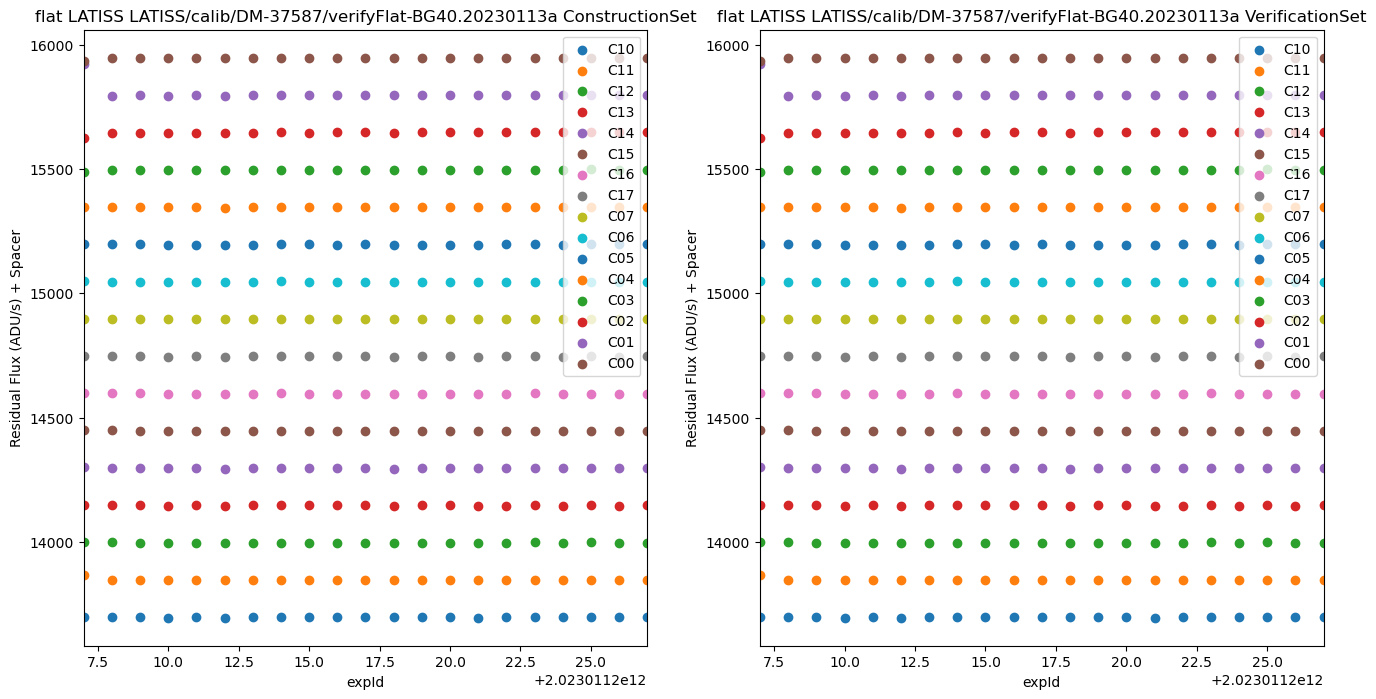

RXX_S00 Continue? [h, c, q, p, #] 


In [8]:
# Plot flux as a function of exposure id, to look for time trends.
continueDisplay = True
for detector in camera:
    detName = detector.getName()

    horizontalSpace = 0.0
    verticalSpace = 150
    plt.figure(figsize=(8, 8))
    fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
    for axis, chunk in zip(axes, [0, 1]):
        for spacer, amp in enumerate(detector.getAmplifiers()):
            axis.scatter(np.array(ampMeans[detName][amp.getName()]['ID']) + horizontalSpace * spacer,
                         np.array(ampMeans[detName][amp.getName()]['MEAN']) /
                         np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + verticalSpace * spacer,
                        label=amp.getName())
        axis.set_xlabel("expId")
        axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
        if chunk == 0:
            axis.set_xlim(min(expIds), max(expIds)) # This may need editing.
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
        else:
            axis.set_xlim(min(expIds), max(expIds)) # This may need editing.
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")
        axis.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break

<Figure size 800x800 with 0 Axes>

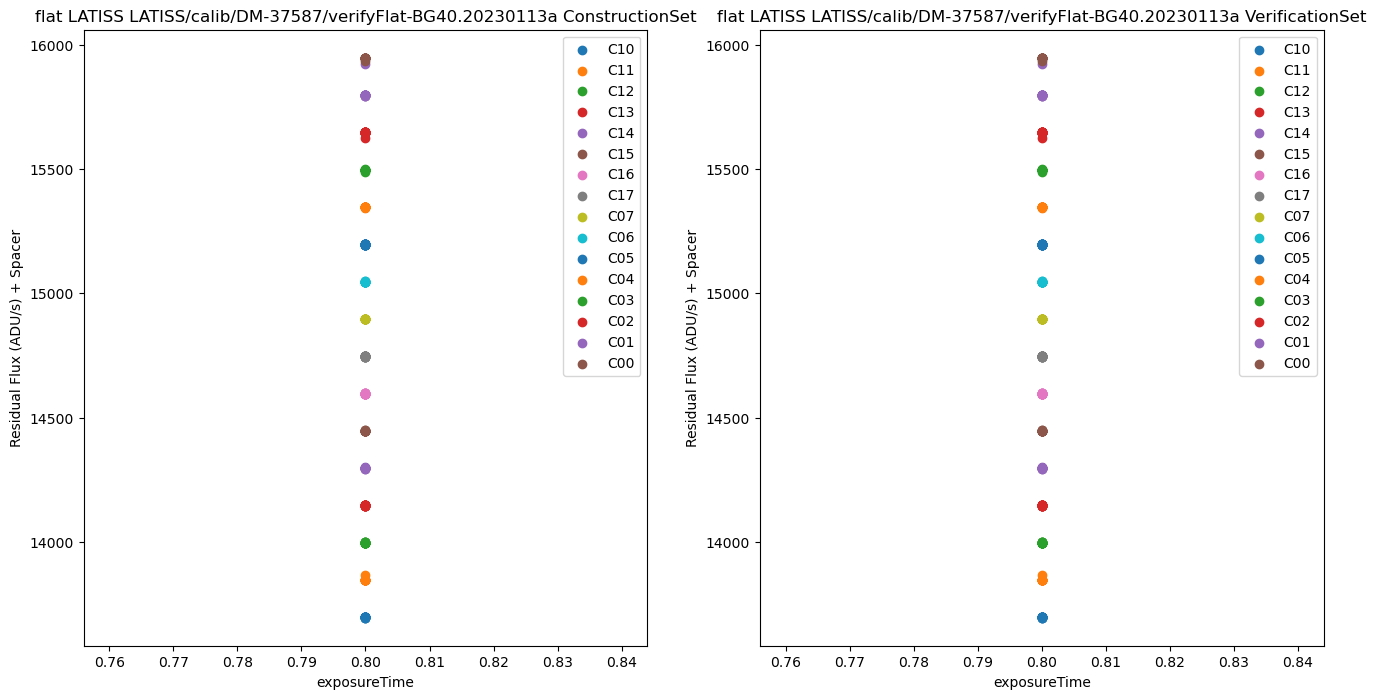

RXX_S00 Continue? [h, c, q, p, #] 


In [9]:
# Plot flux as a function of exposure time, to confirm the residual is flat.
continueDisplay = True
for detector in camera:
    detName = detector.getName()

    horizontalSpace = 0.0
    verticalSpace = 150
    plt.figure(figsize=(8, 8))
    fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
    for axis, chunk in zip(axes, [0, 1]):
        for spacer, amp in enumerate(detector.getAmplifiers()):
            axis.scatter(np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + horizontalSpace * spacer,
                         np.array(ampMeans[detName][amp.getName()]['MEAN']) /
                         np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + verticalSpace * spacer,
                        label=amp.getName())
        axis.set_xlabel("exposureTime")
        axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
        if chunk == 0:
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
        else:
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")
        axis.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break

In [10]:
if haveDisplay:
    display.embed()

In [11]:
# View calibration images:
assert haveDisplay is True, "Please set up a display and set ``haveDisplay`` to true to run this cell."

continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    calib = butler.get(calibType, instrument=cameraName, physical_filter=physical_filter, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

AssertionError: Please set up a display and set ``haveDisplay`` to true to run this cell.

In [12]:
# This block allows the residual images to be scanned for concerns.
assert haveDisplay is True, "Please set up a display and set ``haveDisplay`` to true to run this cell."

blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue
        
            detId = detector.getId()
            residual = butler.get('verifyFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
            detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=0)
            display.mtv(residual)
            display.scale('linear', 'zscale', None)
        
            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break

AssertionError: Please set up a display and set ``haveDisplay`` to true to run this cell.

In [ ]:
# Additional cells follow here.